## Fake Data Detection


### About The Data
This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent. A small proportion of these descriptions are fake or scam which can be identified by the column "fraudulent". 

The data is provide by the University of the Aegean | Laboratory of Information & Communication Systems Security

http://emscad.samos.aegean.gr/

## Dictonary:
-  job_id: Unique ID (int64)
-  title: Title of job description (str)
-  location: Geographical location of the job ad (Example: US, NY, New York)
-  department: Corporate department (e.g. Marketing, Success, Sales, ANDROIDPIT, ...)
-  salary_range: Indicative salary range (e.g. 50,000-60,000 ($))
-  company_profile: A brief company description.
-  description: The details description of the job ad.
-  requirements: Enlisted requirements for the job opening.
-  benefits: Enlisted offered benefits by the employer.
-  telecommuting: True for telecommuting positions. --> remote or not
-  has_company_logo: True if company logo is present.
-  has_questions: True if screening questions are present.
-  employment_type: Type of emplyment (e.g. Full-type, Part-time, Contract, etc.)
-  required_experience: Required Experience (e.g. Executive, Entry level, Intern, etc.)
-  required_education: Required Education (e.g. Doctorate, Master’s Degree, Bachelor, etc)
-  industry: Industry (e.g. Automotive, IT, Health care, Real estate, etc.)
-  function: Position as function in the company (e.g. Consulting, Engineering, Research, Sales etc.)
-  fraudulent: Classifcation target (0, 1)


# Columns to do:
## string manipulation
- title
- company_profile
- description
- requirements
- benefits

## one-hot encode
- location (3.105) - cities and countries --> remove
    - countries = 90 (346 is NA) --> keep
- industry (groups = 131) --> boolean mask (group all with less than 30 into one group) --> create category with missings
- function (groups = 37)  --> create category with missings

- employment_type (groups = 5) 
- required_experience (groups = 7)
- required_education (groups = 13)

## binary (no mising)
- telecommuting
- has_company_logo
- has_questions
- salary_range --> turn into binary (has salary range or not)
- department (groups = 1337) --> binary 

## target
- fraudulent (binary)

## dropping
department (groups = 1337) --> boolean mask (group all with less than 30 into one group) --> drop for now

# Questions
- How to impute data with more sophisticated methods?
- How to examine whether values are true NAs or just the result of company size?


In [1]:
# Install dependencies as needed:
import pandas as pd 
from scam_job_detector.ML_logic.data import clean_data
from scam_job_detector.ML_logic.preprocessor import test_preprocessor
from scam_job_detector.ML_logic.model import load_model
from scam_job_detector.ML_logic.shapley import shapley
%load_ext autoreload
%autoreload 2


/home/lars/.pyenv/versions/scam_job_detector/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read file
data_path = '/home/lars/code/syeda-tabassum-rahaman/scam-job-detector/raw_data/fake_job_postings.csv'
df = pd.read_csv(data_path)
# print("First 5 records:", df.head())

In [23]:
import os
import dill
import pandas as pd
from sklearn.metrics import (
    recall_score, precision_score, balanced_accuracy_score, f1_score,
    average_precision_score, precision_recall_curve, roc_auc_score

)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from scam_job_detector.ML_logic.preprocessor import train_preprocessor, test_preprocessor


In [47]:
# Load cleaned dataset

df = pd.read_csv('/home/lars/code/syeda-tabassum-rahaman/scam-job-detector/raw_data/data_cleaned.csv')
print("✅ Clean data loaded")

# Train-test split
X = df.drop(columns=["fraudulent"])
y = df["fraudulent"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

# Preprocess once
X_train_pp = train_preprocessor(X_train)
X_test_pp = test_preprocessor(X_test)

# Paths for saving models
base_path = "/home/lars/code/syeda-tabassum-rahaman/scam-job-detector/scam_job_detector/"
models_folder = os.path.join(base_path, "models")
os.makedirs(models_folder, exist_ok=True)

model_path = os.path.join(models_folder, "final_model.dill")


xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    learning_rate=0.1,
    min_child_weight=1,
    reg_lambda=1,
    max_depth=11,
    n_estimators=275
)

xgb.fit(X_train_pp, y_train)
with open(model_path, "wb") as f:
    dill.dump(xgb, f)

y_pred = xgb.predict(X_test_pp)
y_pred_xgb_proba =xgb.predict_proba(X_test_pp)[:, 1]
print(f'''
    Model Performance
    Recall: {recall_score(y_test, y_pred)},
    Precision: {precision_score(y_test, y_pred)},
    Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)},
    F1 Score: {f1_score(y_test, y_pred)},
    AUC: {roc_auc_score(y_test, y_pred_xgb_proba)}
    Probas: {y_pred_xgb_proba[y_pred_xgb_proba >= .05]}
    ''')

✅ Clean data loaded
Preprocessor saved at /home/lars/code/syeda-tabassum-rahaman/scam-job-detector/models/preprocessor.dill

    Model Performance
    Recall: 0.7052023121387283,
    Precision: 0.9606299212598425,
    Balanced Accuracy: 0.8518665101686882,
    F1 Score: 0.8133333333333334,
    AUC: 0.990258510426876
    Probas: [0.98724174 0.9972892  0.17236161 0.9484202  0.99755716 0.33711404
 0.11216172 0.0527542  0.07450791 0.29281938 0.95040005 0.99314594
 0.99789053 0.11313125 0.18231471 0.99947876 0.9735118  0.09295925
 0.3499849  0.11079244 0.80060434 0.05685522 0.07184    0.99858034
 0.9926118  0.77589303 0.9455377  0.9930774  0.1707122  0.96976465
 0.70107824 0.09708437 0.9956136  0.2102971  0.94156533 0.05633546
 0.09564963 0.6863225  0.9970131  0.09416355 0.98107326 0.10622044
 0.4554999  0.9955236  0.8614945  0.9952443  0.1730997  0.18002139
 0.9781436  0.9904323  0.98929787 0.905352   0.9943329  0.9967393
 0.8597618  0.98805016 0.997209   0.36853448 0.5480139  0.5417771
 0

(0.0, 1.0)

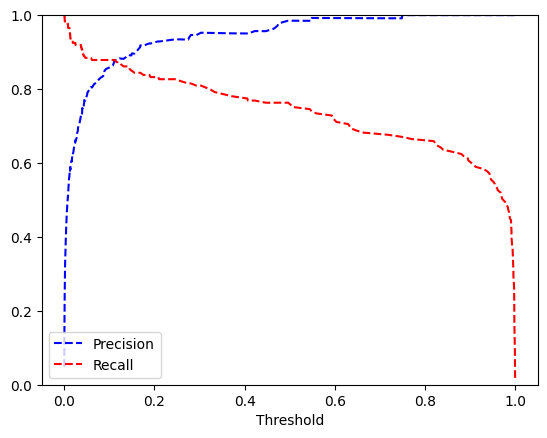

In [17]:
import matplotlib.pyplot as plt
precision, recall, threshold = precision_recall_curve(y_test, y_pred_xgb_proba)

plt.plot(threshold, precision[:-1], 'b--', label='Precision')
plt.plot(threshold, recall[:-1], 'r--', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='lower left')
plt.ylim([0,1])


In [22]:
import numpy as np
def prt(arr, value):
    array = np.asarray(arr)
    idx = np.where(array[:-1] == value)[0][0]
    return precision[idx], recall[idx], threshold[idx]

prt(precision, 0.2)

(np.float64(0.2), np.float64(0.9942196531791907), np.float32(0.00062811136))

In [46]:
import pandas as pd

def custom_pred(y_test, y_pred, y_prob, threshold):
    
    d = pd.DataFrame({
        'y_test': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob
        })
    
    likely = d[d.y_prob >= threshold]
    unlikely = d[d.y_prob < threshold]

    TP = likely[likely.y_test == 1].shape[0]
    FP = likely[likely.y_test == 0].shape[0]
    TN = unlikely[unlikely.y_test == 0].shape[0]
    FN = unlikely[unlikely.y_test == 1].shape[0]

    recall = TP/(TP+FN)
    precision = TP/(TP+FP)

    return f'Recall: {recall}, Precision: {precision}; {FN}; {likely.shape[0]}; {unlikely.shape[0]}'

custom_pred(y_test, y_pred, y_pred_xgb_proba, 0.4)

'Recall: 0.7861271676300579, Precision: 0.9855072463768116; 37; 138; 3438'

In [31]:
df.shape

(17880, 7)

In [21]:
X_new = df.sample(1).drop(columns='fraudulent')
type(X_new)

pandas.core.frame.DataFrame

In [22]:
import sys
SRC = "/home/lars/code/syeda-tabassum-rahaman/scam-job-detector/src"
sys.path.insert(0, SRC)

In [23]:
# Loads preprocessed features into X_processed variable
X_new_cleaned = clean_data(X_new)

✅ data cleaned


In [24]:
X_new_cleaned

,has_company_logo,employment_type,industry,function,job_description,country
11660,1,Full-time,Civic & Social Organization,Health Care Provider,fulltime caregiver position b shy sweet young ...,US


In [25]:
X_new_preprocessed = test_preprocessor(X_new_cleaned)


In [27]:
shap_features_text, shap_text_list, shap_features_binary ,shap_values_binary, shap_features_country, shap_values_country = shapley(X_new_preprocessed)

[autoreload of scam_job_detector.ML_logic.shapley failed: Traceback (most recent call last):
  File "/home/lars/.pyenv/versions/scam_job_detector/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/lars/.pyenv/versions/scam_job_detector/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/lars/.pyenv/versions/3.10.6/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/lars/code/syeda-tabassum-rahaman/scam-job-detector/scam_job_detector/ML_logic/shapley.py", line 5, in <module>
    from wordcloud import WordCloud
ModuleNotFoundError: No module named 'wordcloud

✅ Model loaded
✅ Preprocessor loaded
✅ Clean data loaded


  0%|          | 0/1 [00:00<?, ?it/s]/home/lars/.pyenv/versions/scam_job_detector/lib/python3.10/site-packages/xgboost/data.py:1281: UserWarning: Unknown data type: <class 'scipy.sparse._lil.lil_matrix'>, trying to convert it to csr_matrix
  warnings.warn(
100%|██████████| 1/1 [01:10<00:00, 70.90s/it]


ValueError: not enough values to unpack (expected 6, got 2)

In [ ]:
print(shap_features_text, shap_values_list, shap_features_binary ,shap_values_binary)


['columntransformer__tfidfvectorizer__abapbw', 'columntransformer__tfidfvectorizer__abapbw backend', 'columntransformer__tfidfvectorizer__abapbw security', 'columntransformer__tfidfvectorizer__abaqus', 'columntransformer__tfidfvectorizer__abaqus element', 'columntransformer__tfidfvectorizer__abatement', 'columntransformer__tfidfvectorizer__abc', 'columntransformer__tfidfvectorizer__abc cbs', 'columntransformer__tfidfvectorizer__abc productsupply', 'columntransformer__tfidfvectorizer__abc sales']


In [18]:
print(list2[100:110])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [13]:


# Loading the model.
model = load_model()

# Generate prediction based up processed features.
prediction = model.predict(X_new_preprocessed)[0]
prediction_proba = model.predict_proba(X_new_preprocessed)[0][1]

# model.classes_

✅ Model loaded


In [15]:
prediction_proba.tolist()

2.9556726076407358e-05

In [ ]:
top5_idx = df["industry"].value_counts().head(10).index
df["industry"] = df["industry"].where(df["industry"].isin(top5_idx), "Other")


# extracting country ID
df['country'] = df['location'].astype(str).apply(lambda x: x.split(',')[0])
top5_idx = df["country"].value_counts().head(10).index
df["country"] = df["country"].where(df["country"].isin(top5_idx), "Other")


top5_idx = df["function"].value_counts().head(10).index
df["function"] = df["function"].where(df["function"].isin(top5_idx), "Other")


In [ ]:
# text columns for TF-IDF Vectorizer
text_columns = [
        'title',
        'company_profile',
        'description',
        'requirements',
        'benefits'
]
df[text_columns] = df[text_columns].fillna("").astype(str)

df["job_description"] = df[text_columns].agg(" ".join, axis=1).str.strip()
# Clean text data
df['job_description'] = df['job_description'].fillna('missing value')

In [ ]:
# counts = df["employment_type"].value_counts()
# small = counts[counts < 100].index

df["employment_type_grp"] = df["employment_type"].where(~df["employment_type"].isin("Contract"), "Other")
df["employment_type_grp"].value_counts().nunique()

employment_type
Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: count, dtype: int64

In [4]:
print(f'''
Shape: {df.shape}
Size: {df.size}
Unique Ids: {df.job_id.nunique()}
Locations: {df.location.nunique()}
Departments: {df.department.nunique()}; {df.department.unique()}
Salary Range: {df.salary_range.describe()}
Column names: {df.columns}

'''
)


Shape: (17880, 18)
Size: 321840
Unique Ids: 17880
Locations: 3105
Departments: 1337; ['Marketing' 'Success' nan ... 'Admin - Clerical' 'Administrative Dept'
 'Hospitality']
Salary Range: count     2868
unique     874
top        0-0
freq       142
Name: salary_range, dtype: object
Column names: Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')




In [12]:
import numpy as np
list1 = np.abs([
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    -0.006677107826074306
  ])

np.argmax(list1)

np.int64(10)

In [13]:
df.employment_type.unique()

array(['Other', 'Full-time', nan, 'Part-time', 'Contract', 'Temporary'],
      dtype=object)

In [6]:
industry = df.industry.unique().tolist()


import json
with open("/home/lars/code/Lars-Koenig-Git/scam_job_detector/data/industry.json", "w", encoding="utf-8") as f:
    json.dump(industry, f, ensure_ascii=False, indent=2)

In [7]:
employment_type = df.employment_type.unique().tolist()


import json
with open("/home/lars/code/Lars-Koenig-Git/scam_job_detector/data/employment_type.json", "w", encoding="utf-8") as f:
    json.dump(employment_type, f, ensure_ascii=False, indent=2)

In [9]:
function = df.function.unique().tolist()
function


['Marketing',
 'Customer Service',
 'Other',
 'Sales',
 'Health Care Provider',
 'Information Technology',
 'Engineering',
 'Administrative',
 'Design',
 'Education']

In [10]:

import json
with open("/home/lars/code/Lars-Koenig-Git/scam_job_detector/data/function.json", "w", encoding="utf-8") as f:
    json.dump(function, f, ensure_ascii=False, indent=2)

In [32]:
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
from pathlib import Path

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean raw data by
    - Creating new features for columns with missing values above >30% as binary features: missing = 0, not missing = 1
    - Cleaning text data by removing stopwords, digits, lamatizing, etc.
    - 
    """
    def preprocessing(sentence):

        stop_words = set(stopwords.words('english'))

        # remove punctuation
        for punctuation in string.punctuation:
            sentence = sentence.replace(punctuation, '')

        # set to lowercase
        sentence = sentence.lower()

        # remove numbers
        for char in string.digits:
            sentence = ''.join(char for char in sentence if not char.isdigit())

        # tokenize
        tokens = word_tokenize(sentence)

        # removing stop words
        tokens = [word for word in tokens if word not in stop_words]

        # lemmatize
        tokens = [WordNetLemmatizer().lemmatize(word, pos='v') for word in tokens]

        return ' '.join(tokens)

    # path = Path('.')
    df = pd.read_csv('../raw_data/fake_job_postings.csv')
    print('dataset loaded')

    # Creating binary columns for missing values:
    df['department_binary'] = df['department'].map(lambda x: 0 if pd.isna(x) else 1)
    
    df['salary_range_binary'] = df['salary_range'].map(lambda x: 0 if pd.isna(x) else 1)
    
    # Clean text data
    cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']

    df = df.copy()

    for col in cols:
        df[col] = df[col].fillna('missing value')

    for col in cols:
        df[col] = df[col].apply(preprocessing)
    
    # extracting country ID
    df['country'] = df['location'].astype(str).apply(lambda x: x.split(',')[0])

    # dropping columns
    df.drop(columns=['salary_range', 'department', 'location', 'job_id'], inplace=True)
    

    print("✅ data cleaned")

    return df


In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import FunctionTransformer


# catagorical columns for One-Hot Encoding
categorical_columns = [
    'country',
    'industry',
    'function',
    'employment_type'
]
# ordinal columns for Ordinal Encoding
ordinal_columns = [
    'required_experience',
    'required_education'
]
#binary columns for binary encoding
binary_columns = ['has_company_logo', 'has_questions', 'department_binary', 'salary_range_binary']

#text columns for TF-IDF Vectorizer
text_columns = [
        'title',
        'company_profile',
        'description',
        'requirements',
        'benefits'
]

#reference lists for ordinal encoding
experience_order = [
    "Not Applicable",
    "Unknown",
    "Internship",
    "Entry level",
    "Associate",
    "Mid-Senior level",
    "Director",
    "Executive"
]

education_order = [
    "Unknown",
    "High School or equivalent",
    "Vocational",
    "Certification",
    "Some College Coursework Completed",
    "Associate Degree",
    "Bachelor's Degree",
    "Professional",
    "Master's Degree"
]


# preprocessor pipeline
def preprocessing_pipeline() -> ColumnTransformer:

    cat_transformer = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        OneHotEncoder(handle_unknown='ignore')
    )
    ordinal_transformer = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        OrdinalEncoder(
        categories=[experience_order, education_order],
        handle_unknown="use_encoded_value",
        unknown_value=-1)
    )
    binary_transformer = make_pipeline(
        SimpleImputer(strategy='most_frequent', fill_value=0),
        OneHotEncoder(handle_unknown='ignore')
    )

    def combine_text(X):
        return X[text_columns].fillna("").agg(" ".join, axis=1)
    
    text_transformer = make_pipeline(
        FunctionTransformer(combine_text, validate=False),
        TfidfVectorizer(max_features=5000)
    )

    
    preprocessor = make_column_transformer(
        (cat_transformer, categorical_columns),
        (ordinal_transformer, ordinal_columns),
        (binary_transformer, binary_columns),
        (text_transformer, text_columns)
    )
    return preprocessor

# train preprocessor pipeline
def train_preprocessor(X_train: pd.DataFrame, X_test: pd.DataFrame) -> np.ndarray:
    preprocessor = preprocessing_pipeline()
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)
    return X_train_preprocessed, X_test_preprocessed



In [ ]:
df = clean_data(df)
# Extract X and y
X = df.drop(columns=['fraudulent'])
y = df['fraudulent']
# Make train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# preprocess train and test data
X_train_preprocessed, X_test_preprocessed = train_preprocessor(X_train, X_test)
# X_test_preprocessed = test_preprocessor(X_test)

dataset loaded
✅ data cleaned


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression

df = clean_data(df)
# Extract X and y
X = df.drop(columns=['fraudulent'])
y = df['fraudulent']
# Make train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# preprocess train and test data
X_train_preprocessed, X_test_preprocessed = train_preprocessor(X_train, X_test)
# X_test_preprocessed = test_preprocessor(X_test)

cv = StratifiedKFold(n_splits=5)

pipe = Pipeline([
    # ("clean_preproc", clean_preproc),
    ("classifier", LogisticRegression(max_iter=1000))
])

cross_val_score(pipe, X_train_preprocessed, y_train, cv=cv).mean()

cross_model = cross_validate(pipe, X_train_preprocessed, y_train, cv=cv)
cross_model


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, accuracy_score

model = LogisticRegression(max_iter=1000)

result = model.fit(X_train_preprocessed, y_train)

result.score

y_pred = result.predict(X_test_preprocessed)

print(recall_score(y_test, y_pred), precision_score(y_test, y_pred), accuracy_score(y_test, y_pred))



np.float64(0.9738533643916376)

{'fit_time': array([0.61700773, 0.65386415, 0.56823897, 0.60018778, 0.63627195]),
 'score_time': array([0.00219345, 0.00320959, 0.0033884 , 0.00193262, 0.00251102]),
 'test_score': array([0.97413492, 0.97553303, 0.97203775, 0.9751835 , 0.97237762])}

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, accuracy_score

model = LogisticRegression(max_iter=1000)

result = model.fit(X_train_preprocessed, y_train)

result.score

<bound method ClassifierMixin.score of LogisticRegression(max_iter=1000)>

In [29]:
y_pred = result.predict(X_test_preprocessed)

print(recall_score(y_test, y_pred), precision_score(y_test, y_pred), accuracy_score(y_test, y_pred))



0.5606936416184971 0.97 0.9779082774049217


In [8]:
import os
import dill
import pandas as pd
from sklearn.metrics import (
    recall_score, precision_score, balanced_accuracy_score, f1_score,
    average_precision_score
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from scam_job_detector.ML_logic.preprocessor import train_preprocessor, test_preprocessor
%load_ext autoreload
%autoreload 2
# import scam_job_detector.ML_logic.preprocessor as pre
# print("Imported from:", pre.__file__)
# print("Functions available:", dir(pre))
import sys

In [3]:
import sys
sys.path.insert(0, "/home/lars/code/syeda-tabassum-rahaman/scam-job-detector/src")

In [9]:
import sys, importlib

# 1) remove already-loaded installed package from this kernel
for k in list(sys.modules):
    if k == "scam_job_detector" or k.startswith("scam_job_detector."):
        del sys.modules[k]

# 2) put your repo's src first (src-layout)
SRC = "/home/lars/code/syeda-tabassum-rahaman/scam-job-detector/src"
sys.path.insert(0, SRC)

# 3) now check what would be imported
spec = importlib.util.find_spec("scam_job_detector")
print("spec:", spec.origin)

# 4) import and verify
import scam_job_detector
print("imported from:", scam_job_detector.__file__)

spec: /home/lars/code/syeda-tabassum-rahaman/scam-job-detector/scam_job_detector/__init__.py
imported from: /home/lars/code/syeda-tabassum-rahaman/scam-job-detector/scam_job_detector/__init__.py


In [14]:
# 'PROJECT_ROOT = Path("/home/lars/code/Lars-Koenig-Git/scam_job_detector/")  # folder that contains your package folder
# sys.path.insert(0, str(PROJECT_ROOT'))

# Load cleaned dataset
from pathlib import Path

# usually the folder where you launched jupyter, or where the notebook lives
base_path = Path.cwd().resolve().parent
clean_data_path = base_path / "raw_data" / "data_cleaned.csv"

df = pd.read_csv(clean_data_path)
print("✅ Clean data loaded")

# Train-test split
X = df.drop(columns=["fraudulent"])
y = df["fraudulent"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocess once
X_train_pp, preprocessor = train_preprocessor(X_train)
X_test_pp = test_preprocessor(X_test)

# Paths for saving models
models_folder = os.path.join(base_path, "models")
os.makedirs(models_folder, exist_ok=True)

winner_path = os.path.join(models_folder, "model_winner.dill")


xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42,
    learning_rate=0.1,
    max_depth=11,
    n_estimators=275
)

xgb.fit(X_train_pp, y_train)

y_pred = xgb.predict(X_test_pp)

print(f'''
    Model Performance
    Recall: {recall_score(y_test, y_pred)},
    Precision: {precision_score(y_test, y_pred)},
    Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)},
    F1 Score: {f1_score(y_test, y_pred)}
    ''')


✅ Clean data loaded
Preprocessor saved at /home/lars/code/syeda-tabassum-rahaman/scam-job-detector/models/preprocessor.dill

    Model Performance
    Recall: 0.7398843930635838,
    Precision: 0.9922480620155039,
    Balanced Accuracy: 0.8697952673516567,
    F1 Score: 0.847682119205298
    


In [12]:
y_train


7530     0
129      0
4640     0
402      0
13218    0
        ..
1841     0
11852    0
10870    0
565      0
13398    0
Name: fraudulent, Length: 14304, dtype: int64

In [ ]:
import os
import dill
import pandas as pd
from sklearn.metrics import (
    recall_score, precision_score, balanced_accuracy_score, f1_score,
    average_precision_score, precision_recall_curve

)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from scam_job_detector.ML_logic.preprocessor import train_preprocessor, test_preprocessor

def initialize_all_grid_searches(run_logreg=True, run_xgb=True):
    """
    Run grid-searches for baseline models only if requested.
    Preprocess data only once.
    Save best estimators for each model.
    Finally compute the best model ("winner model") based on test AP score.
    """

    # Load cleaned dataset
    base_path = os.path.dirname(os.path.dirname(os.path.dirname(__file__)))
    clean_data_path = os.path.join(base_path, "raw_data", "data_cleaned.csv")

    df = pd.read_csv(clean_data_path)
    print("✅ Clean data loaded")

    # Train-test split
    X = df.drop(columns=["fraudulent"])
    y = df["fraudulent"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Preprocess once
    X_train_pp, preprocessor = train_preprocessor(X_train)
    X_test_pp = test_preprocessor(X_test)

    # Paths for saving models
    models_folder = os.path.join(base_path, "models")
    os.makedirs(models_folder, exist_ok=True)

    logreg_path = os.path.join(models_folder, "model_logreg.dill")
    xgb_path = os.path.join(models_folder, "model_xgb.dill")
    winner_path = os.path.join(models_folder, "model_winner.dill")

    # Store results for winner selection
    model_scores = {}

    # ====================================================== #
    # 1️⃣ LOGISTIC REGRESSION GRID SEARCH (if requested)
    # ====================================================== #
    if run_logreg:
        print("\n🔍 Running Logistic Regression Grid Search...")

        param_grid_logreg = {
            'penalty': ['l1', 'l2'],
            'class_weight': [None, 'balanced'],
            'solver': ['liblinear']
        }

        grid_lr = GridSearchCV(
            LogisticRegression(),
            param_grid_logreg,
            cv=5,
            scoring='average_precision',
            n_jobs=-1
        )
        grid_lr.fit(X_train_pp, y_train)

        best_lr = grid_lr.best_estimator_

        with open(logreg_path, "wb") as f:
            dill.dump(best_lr, f)

        # Results
        print("✅ Grid search for LR completed")

        # Inspect best estimator:
        print(f"Best score: {grid_lr.best_score_}")
        print(f"Best parameters:, {grid_lr.best_params_}")
        print(f"Best estimator:, {grid_lr.best_estimator_}")

        # model performance on test set
        y_pred = grid_lr.predict(X_test_pp)
        print(f'''
            Model Performance
            Recall: {recall_score(y_test, y_pred)},
            Precision: {precision_score(y_test, y_pred)},
            Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)},
            F1 Score: {f1_score(y_test, y_pred)}
            ''')

    else:
        print("\n📂 Loading previously saved Logistic Regression model...")
        if os.path.exists(logreg_path):
            with open(logreg_path, "rb") as f:
                best_lr = dill.load(f)
        else:
            best_lr = None

    # Evaluate LR if available
    if best_lr is not None:
        y_pred_lr = best_lr.predict(X_test_pp)
        ap_lr = average_precision_score(y_test, y_pred_lr)
        model_scores["logreg"] = (ap_lr, best_lr)
        print(f"🔎 Logistic Regression AP on test: {ap_lr:.4f}")

    # ====================================================== #
    # 2️⃣ XGBOOST GRID SEARCH (if requested)
    # ====================================================== #
    if run_xgb:
        print("\n🔍 Running XGBoost Grid Search...")

        param_grid_xgb = {

            'n_estimators': [275], #[260, 275, 290]
            'max_depth': [11], # [11, 12, 13]
            'learning_rate': [0.1],

        }
        xgb = XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_jobs=-1,
            random_state=42
        )

        grid_xgb = GridSearchCV(
            xgb,
            param_grid_xgb,
            cv=5,
            scoring='average_precision',
            n_jobs=-1,
            verbose=1
        )
        grid_xgb.fit(X_train_pp, y_train)

        best_xgb = grid_xgb.best_estimator_

        with open(xgb_path, "wb") as f:
            dill.dump(best_xgb, f)

        print(f"✅ Saved XGBoost model at {xgb_path}")
                # Results
        print("✅ Grid search for XGboost completed")

        # Inspect best estimator:
        print(f"Best score: {grid_xgb.best_score_}")
        print(f"Best parameters:, {grid_xgb.best_params_}")
        print(f"Best estimator:, {grid_xgb.best_estimator_}")

        # model performance on test set
        y_pred = best_xgb.predict(X_test_pp)
        print(f'''
            Model Performance
            Recall: {recall_score(y_test, y_pred)},
            Precision: {precision_score(y_test, y_pred)},
            Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)},
            F1 Score: {f1_score(y_test, y_pred)}
            ''')


    else:
        print("\n📂 Loading previously saved XGBoost model...")
        if os.path.exists(xgb_path):
            with open(xgb_path, "rb") as f:
                best_xgb = dill.load(f)
        else:
            best_xgb = None

    # Evaluate XGB if available
    if best_xgb is not None:
        y_pred_xgb = best_xgb.predict(X_test_pp)
        y_pred_xgb_proba = best_xgb.predict_proba(X_test_pp)[:, 1]
        ap_xgb = average_precision_score(y_test, y_pred_xgb_proba)
        model_scores["xgb"] = (ap_xgb, best_xgb)
        print(f"🔎 XGBoost AP on test: {ap_xgb:.4f}")

    # ====================================================== #
    # 3️⃣ CHOOSE THE WINNER MODEL
    # ====================================================== #
    if len(model_scores) == 0:
        print("❌ No models available for comparison. Nothing to save.")
        return None

    winner_name = max(model_scores, key=lambda k: model_scores[k][0])
    winner_score, winner_model = model_scores[winner_name]

    with open(winner_path, "wb") as f:
        dill.dump(winner_model, f)

    print(f"\n🏆 WINNER MODEL: {winner_name}  (AP={winner_score:.4f})")
    print(f"💾 Saved at {winner_path}")

    return None

# Thoughts

- For the basic ML Pipeline, we vectorize each of the descriptions seperately, add these vectors along with metainformation to train the model.
- For deep learning, we will create different paths
    1. Creating one document per entry by merging all information in a systematic way.
    2. Creating a meta-data sentence, and leave all description parts seperated. We will then train one moddel per part. At theend we will train a model taking the probabilities for each part to get to a desion.
    3. Same as 2. just that we will train one model taking all parts as inputs


In [1]:
import os
from langchain.chat_models import init_chat_model
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.messages import HumanMessage, AIMessage, SystemMessage


In [2]:
if not os.getenv("GOOGLE_API_KEY"):
    print("❌ Error: Key not found. Check your .env path and file content.")
else:
    print("✅ Key loaded successfully!")

✅ Key loaded successfully!


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_output_tokens=200,
)

In [10]:
id = 1

In [20]:
system_msg = SystemMessage(
    """You are screening job offers for three variables:

    1. Country: Insert one of the following: "Missing": "Not listed in job offer",  "Other": "Not included in list",  "US": "United States of America",  "NZ": "New Zealand",  "DE": "Germany",  "GB": "United Kingdom",  "AU": "Australia",  "CA": "Canada",  "IN": "India",  "GR": "Greece",  "PH": "Philippines"
    2. Industry: "Missing",   "Other",  "Marketing and Advertising",  "Computer Software",  "Hospital & Health Care",  "Information Technology and Services",  "Financial Services",  "Internet",  "Telecommunications",  "Consumer Services",  "Education Management"
    3. Employment_type:   "Missing",  "Other",  "Full-time",  "Part-time",  "Contract",  "Temporary" 

    Please always select "Other", when you are sure that the country, industry, or employment_type is mentioned within the job add but not one of the provided examples.
    Never assume anything which is not written in the job offer. When you can not extract any value metnioned in the list and not select "other", always set the value to missing.

    The output should be only three values in the order: Country, Industry, Emplyment_type
    """
    )

human_msg = "Please search the following job description add and provide the the values for the three categories Country, Industry, Employment_type, without any other text."

job_description = HumanMessage(human_msg + "\n" + df['job_description'][id])

messages = [system_msg, job_description]


In [ ]:
response = model.invoke(messages)

# Display the response

response.text

In [ ]:
df["country"][id], df["industry"][id], df["employment_type"][id]

('NZ', 'Marketing and Advertising', 'Full-time')